<a href="https://colab.research.google.com/github/skhosanam/ml-dl-classification/blob/main/Deep_learning_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install transformers

In [ ]:
#CNN+DistilBERT embeddings

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


In [2]:
from google.colab import files
uploaded = files.upload()

Saving fakeNews.csv to fakeNews (2).csv
Saving trueNews.csv to trueNews (2).csv


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/2
380/380 [==============================] - 536s 1s/step - loss: 0.0260 - accuracy: 0.9926 - val_loss: 0.0065 - val_accuracy: 0.9987
Epoch 2/2
95/95 [==============================] - 39s 392ms/step
Accuracy: 0.525, Sensitivity: 0.507, Precision: 0.508, F1 Score: 0.507, ROC AUC: 0.529


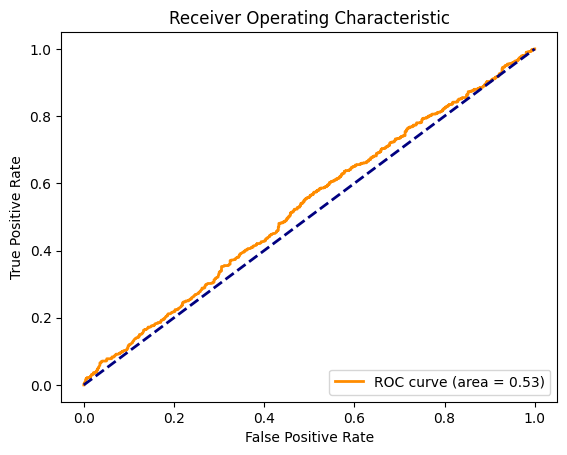

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine datasets and add labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df], ignore_index=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to tokenize and encode texts
def encode_texts(texts):
    return tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=128, return_tensors='tf')

# Encode training and testing data
train_encodings = encode_texts(X_train.tolist())
test_encodings = encode_texts(X_test.tolist())

# Model building function
def build_model():
    distilbert_base = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")
    distilbert_output = distilbert_base(input_ids, attention_mask=attention_mask)[0]
    conv_layer = Conv1D(filters=64, kernel_size=2, activation='relu')(distilbert_output)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    dropout_layer = Dropout(0.2)(pooling_layer)
    output = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Convert to TensorFlow datasets with optimizations
def convert_to_tf_dataset(encodings, labels, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": encodings['input_ids'], "attention_mask": encodings['attention_mask']}, labels))
    dataset = dataset.cache()
    dataset = dataset.shuffle(10000).batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = convert_to_tf_dataset(train_encodings, y_train, batch_size=16)
test_dataset = convert_to_tf_dataset(test_encodings, y_test, batch_size=16)

# Build, compile, and train the model
model = build_model()
optimizer = Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=2, validation_data=test_dataset)

# Evaluation and plotting
def evaluate_model(model, dataset, y_true):
    predictions = model.predict(dataset).flatten()
    y_pred = (predictions > 0.5).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)  # Direct calculation of sensitivity (recall)
    roc_auc = roc_auc_score(y_true, predictions)

    print(f"Accuracy: {accuracy:.3f}, Sensitivity: {sensitivity:.3f}, Precision: {precision:.3f}, F1 Score: {f1:.3f}, ROC AUC: {roc_auc:.3f}")

    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc_val = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

evaluate_model(model, test_dataset, y_test.values)


In [ ]:
##CNN+Word2Vec embeddings

Epoch 1/5
171/171 [==============================] - 3s 16ms/step - loss: 0.0873 - accuracy: 0.9700 - val_loss: 0.0399 - val_accuracy: 0.9885
Epoch 2/5
171/171 [==============================] - 3s 15ms/step - loss: 0.0373 - accuracy: 0.9905 - val_loss: 0.0349 - val_accuracy: 0.9885
Epoch 3/5
171/171 [==============================] - 3s 15ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 0.0294 - val_accuracy: 0.9885
Epoch 4/5
171/171 [==============================] - 3s 15ms/step - loss: 0.0251 - accuracy: 0.9921 - val_loss: 0.0289 - val_accuracy: 0.9885
Epoch 5/5
48/48 [==============================] - 0s 4ms/step
Accuracy: 0.9934123847167325, F1 Score: 0.9931412894375856, Sensitivity: 0.9890710382513661, Precision: 0.9972451790633609, ROC AUC: 0.9990614441246403


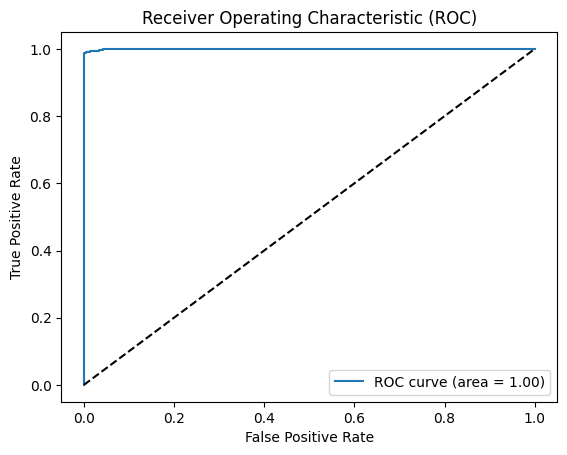

In [50]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming the datasets are loaded as described
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine datasets and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]  # Remove all numbers and punctuation
    return ' '.join(text)  # Return processed text as a single string

# Update to preprocess and then fit the tokenizer on processed texts
X_train_processed = [preprocess_text(text) for text in X_train]
X_test_processed = [preprocess_text(text) for text in X_test]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_processed)

X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)

max_seq_length = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Assuming Word2Vec model is trained as described
# Update: Train on processed sentences
sentences = [sentence.split() for sentence in X_train_processed]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Build CNN model
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1)

predictions = model.predict(X_test_pad)
predicted_labels = (predictions > 0.5).astype(int)

acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
sensitivity = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, predictions)

print(f"Accuracy: {acc}, F1 Score: {f1}, Sensitivity: {sensitivity}, Precision: {precision}, ROC AUC: {roc_auc}")

fpr, tpr, _ = roc_curve(y_test, predictions)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
!pip install tensorflow
!pip install transformers
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import gensim
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine datasets and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)


In [ ]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]  # Remove all numbers and punctuation
    return text

sentences = [preprocess_text(text) for text in X_train]


In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)


In [ ]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_seq_length = 500  # Adjust based on dataset
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Create an embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # Should match the Word2Vec vector size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [ ]:
# Build LSTM model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
171/171 [==============================] - 68s 383ms/step - loss: 0.0885 - accuracy: 0.9779 - val_loss: 0.0416 - val_accuracy: 0.9852
Epoch 2/5
171/171 [==============================] - 64s 372ms/step - loss: 0.0395 - accuracy: 0.9887 - val_loss: 0.0161 - val_accuracy: 0.9967
Epoch 3/5
171/171 [==============================] - 63s 370ms/step - loss: 0.0345 - accuracy: 0.9907 - val_loss: 0.0240 - val_accuracy: 0.9967
Epoch 4/5
171/171 [==============================] - 64s 376ms/step - loss: 0.0283 - accuracy: 0.9925 - val_loss: 0.0109 - val_accuracy: 0.9967
Epoch 5/5
171/171 [==============================] - 64s 374ms/step - loss: 0.0233 - accuracy: 0.9932 - val_loss: 0.0105 - val_accuracy: 0.9967


In [46]:
# Make predictions
predictions = model.predict(X_test_pad)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy and F1 score
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
sensitivity = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, predictions)
print(f"Accuracy: {acc}, F1 Score: {f1}, Sensitivity: {sensitivity}, Precision: {precision}, ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_8" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 500) dtype=int32>]


48/48 [==============================] - 38s 744ms/step
Accuracy: 0.48221343873517786, F1 Score: 0.6506666666666667, Sensitivity: 1.0, Precision: 0.48221343873517786, ROC AUC: 0.5


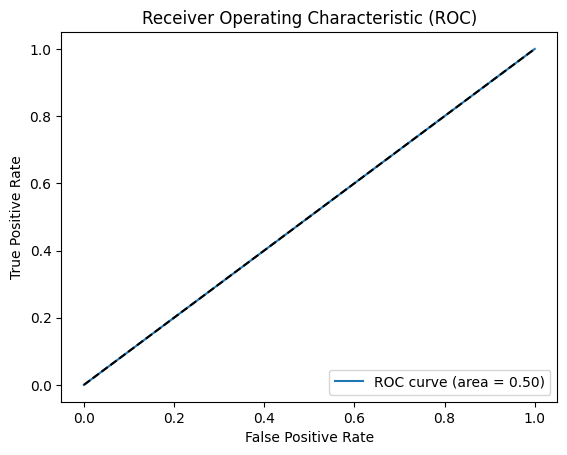

In [45]:
# Corrected prediction to include both input_ids and attention_masks
predictions = model.predict([X_test_ids, X_test_attention])
predicted_labels = (predictions > 0.5).astype(int)

# Calculate metrics
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
sensitivity = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, predictions)

print(f"Accuracy: {acc}, F1 Score: {f1}, Sensitivity: {sensitivity}, Precision: {precision}, ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
######LSTM+Word2Vec embeddings

Epoch 1/5
171/171 [==============================] - 66s 373ms/step - loss: 0.0774 - accuracy: 0.9733 - val_loss: 0.0221 - val_accuracy: 0.9951
Epoch 2/5
171/171 [==============================] - 64s 373ms/step - loss: 0.0370 - accuracy: 0.9892 - val_loss: 0.0305 - val_accuracy: 0.9885
Epoch 3/5
171/171 [==============================] - 63s 369ms/step - loss: 0.0314 - accuracy: 0.9907 - val_loss: 0.0241 - val_accuracy: 0.9934
Epoch 4/5
171/171 [==============================] - 64s 371ms/step - loss: 0.0290 - accuracy: 0.9905 - val_loss: 0.0202 - val_accuracy: 0.9934
Epoch 5/5
48/48 [==============================] - 7s 138ms/step
Accuracy: 0.994729907773386, F1 Score: 0.9945280437756497, Sensitivity: 0.9931693989071039, Precision: 0.9958904109589041, ROC AUC: 0.999308249558531


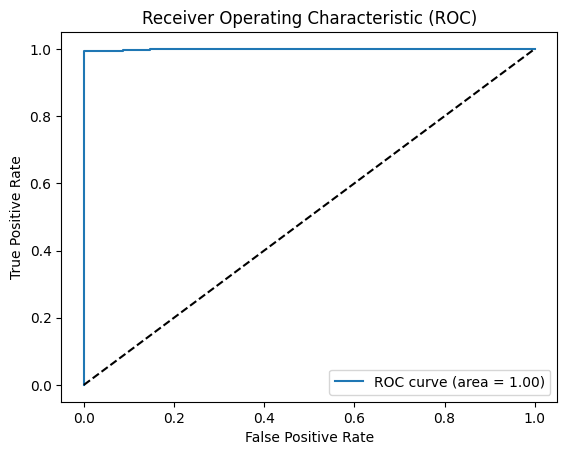

In [49]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Loading datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine datasets and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]  # Remove all numbers and punctuation
    return text

sentences = [preprocess_text(text) for text in X_train]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Convert texts to sequences and pad them
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_seq_length = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Create an embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Build LSTM model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Make predictions
predictions = model.predict(X_test_pad)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate metrics
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
sensitivity = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, predictions)

print(f"Accuracy: {acc}, F1 Score: {f1}, Sensitivity: {sensitivity}, Precision: {precision}, ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
##LSTM+DistilBERT embeddings

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/2
759/759 [==============================] - 679s 873ms/step - loss: 0.6976 - accuracy: 0.4918 - val_loss: 0.6935 - val_accuracy: 0.4822
Epoch 2/2
190/190 [==============================] - 43s 214ms/step
Accuracy: 0.48221343873517786, F1 Score: 0.6506666666666667, Sensitivity: 1.0, Precision: 0.48221343873517786, ROC AUC: 0.5


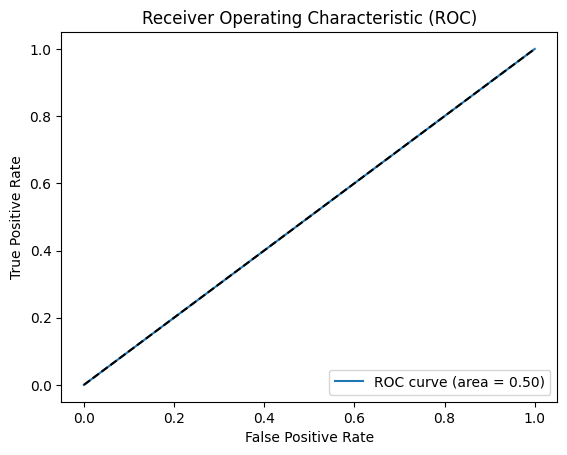

In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load and prepare datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def encode_texts(tokenizer, texts, max_len=512):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return input_ids, attention_masks

X_train_ids, X_train_attention = encode_texts(tokenizer, X_train, max_len=128)
X_test_ids, X_test_attention = encode_texts(tokenizer, X_test, max_len=128)

# Load DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

def build_model(distilbert_model):
    input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")
    distilbert_output = distilbert_model(input_ids, attention_mask=attention_mask)[0]
    lstm_layer = LSTM(units=64, return_sequences=False)(distilbert_output)
    output = Dense(1, activation='sigmoid')(lstm_layer)
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

model = build_model(distilbert_model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_ids, X_train_attention), y_train)).batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_ids, X_test_attention), y_test)).batch(8)

# Train model
model.fit(train_dataset, epochs=2, validation_data=test_dataset)

# Make predictions
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate metrics
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
sensitivity = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, predictions.flatten())

print(f"Accuracy: {acc}, F1 Score: {f1}, Sensitivity: {sensitivity}, Precision: {precision}, ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions.flatten())
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#Hybrid models

In [ ]:
###CNN+LSTM+Word2Vec embeddings

Epoch 1/3
190/190 [==============================] - 6s 19ms/step - loss: 0.2122 - accuracy: 0.9301
Epoch 2/3
190/190 [==============================] - 3s 18ms/step - loss: 0.0534 - accuracy: 0.9847
Epoch 3/3
48/48 [==============================] - 1s 6ms/step
Accuracy: 0.9921
F1 Score: 0.9917
Sensitivity (Recall): 0.9850
Precision: 0.9986
ROC AUC: 0.9992


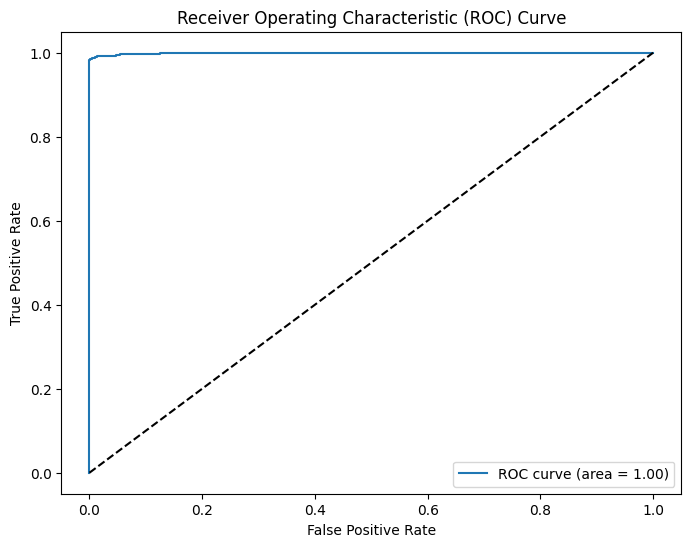

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Load the attached datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Preprocess data
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]  # Remove all numbers and punctuation
    return ' '.join(text)

combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Train Word2Vec model
sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
max_seq_length = max([len(text.split()) for text in X_train])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model architecture with Word2Vec embeddings
input_layer = Input(shape=(max_seq_length,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_seq_length, trainable=False)(input_layer)
conv_layer = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding_layer)
max_pool = MaxPooling1D(pool_size=2)(conv_layer)
lstm_layer = LSTM(32)(max_pool)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=3, batch_size=32)

# Tokenization and padding for test data
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post')

# Evaluate the model
y_pred_probs = model.predict(X_test_padded).flatten()
y_pred_binary = (y_pred_probs >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
sensitivity = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
##CNN+LSTM+DistilBERT embeddings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected i

Epoch 1/3
759/759 [==============================] - 27s 32ms/step - loss: 0.3611 - accuracy: 0.8629
Epoch 2/3
759/759 [==============================] - 24s 32ms/step - loss: 0.0692 - accuracy: 0.9817
Epoch 3/3
48/48 [==============================] - 1s 15ms/step
Accuracy: 0.9908
F1 Score: 0.9904
Recall: 0.9877
Precision: 0.9931
ROC AUC: 0.9994


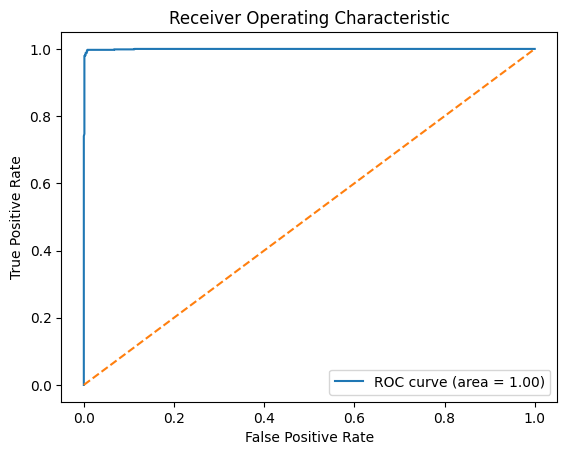

In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
#from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D

# Load the attached datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Preprocess data
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]  # Remove all numbers and punctuation
    return ' '.join(text)

combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenization and padding
max_length = 256
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Extract embeddings from DistilBERT
X_train_embeddings = bert_model(X_train_encodings)[0].numpy()  # Convert tensor to numpy array
X_test_embeddings = bert_model(X_test_encodings)[0].numpy()    # Convert tensor to numpy array

# Function to pad the sequences
def pad_embeddings(embeddings, max_length):
    padded_embeddings = np.zeros((len(embeddings), max_length, embeddings.shape[2]))
    for i, embedding in enumerate(embeddings):
        length = min(max_length, embedding.shape[0])
        padded_embeddings[i, :length] = embedding[:length]
    return padded_embeddings

# Pad the embeddings
X_train_padded = pad_embeddings(X_train_embeddings, max_length)
X_test_padded = pad_embeddings(X_test_embeddings, max_length)

# Create a sequential model for CNN+LSTM
model = Sequential()

# CNN layer
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(max_length, 768)))
model.add(MaxPooling1D(pool_size=4))

# LSTM layer
model.add(LSTM(50))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=3, batch_size=8)

# Evaluate the model
#y_pred = model.predict(X_test_padded)
#y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

#accuracy = accuracy_score(y_test, y_pred_binary)
#f1 = f1_score(y_test, y_pred_binary)

#print(f"Accuracy: {accuracy}")
#print(f"F1 Score: {f1}")

# Evaluate the model
predictions = model.predict(X_test_padded)
y_pred_probs = predictions.flatten()
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Output the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Pre-trained language models

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Preprocess text function
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]
    return ' '.join(text)

# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])
combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Tokenization for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 128
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Load DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Extract embeddings
def get_embeddings(model, tokenized_data):
    return model(tokenized_data)[0][:,0,:].numpy()

X_train_embeddings = get_embeddings(distilbert_model, X_train_encodings)
X_test_embeddings = get_embeddings(distilbert_model, X_test_encodings)

# Build classification model
input_layer = Input(shape=(X_train_embeddings.shape[1],))
dense_layer = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# Custom Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8, beta_2=0.898, epsilon=1e-7)

# Compile model
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_embeddings, y_train, epochs=3, batch_size=8)

# Evaluate model
y_pred = model.predict(X_test_embeddings)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print(f"DistilBERT Classifier - Accuracy: {accuracy}, F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected i

Epoch 1/3
759/759 [==============================] - 2s 1ms/step - loss: 0.2287 - accuracy: 0.9353
Epoch 2/3
759/759 [==============================] - 1s 1ms/step - loss: 0.0907 - accuracy: 0.9725
Epoch 3/3
48/48 [==============================] - 0s 1ms/step
DistilBERT Classifier - Accuracy: 0.9802371541501976, F1 Score: 0.9795918367346939
Confusion Matrix:
[[768  18]
 [ 12 720]]


In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Preprocess text function
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]
    return ' '.join(text)

# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])
combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Tokenization for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 128
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Load DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Extract embeddings
def get_embeddings(model, tokenized_data):
    return model(tokenized_data)[0][:,0,:].numpy()

X_train_embeddings = get_embeddings(distilbert_model, X_train_encodings)
X_test_embeddings = get_embeddings(distilbert_model, X_test_encodings)

# Build classification model
input_layer = Input(shape=(X_train_embeddings.shape[1],))
dense_layer = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# Custom Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8, beta_2=0.898, epsilon=1e-7)

# Compile model
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_embeddings, y_train, epochs=3, batch_size=8)

# Evaluate model
#y_pred = model.predict(X_test_embeddings)
#y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate model and extend with additional metrics
y_pred_probs = model.predict(X_test_embeddings).flatten()  # Use flatten to ensure y_pred_probs is 1D
y_pred_binary = (y_pred_probs > 0.5).astype(int)

#accuracy = accuracy_score(y_test, y_pred_binary)
#f1 = f1_score(y_test, y_pred_binary)
#conf_matrix = confusion_matrix(y_test, y_pred_binary)

#print(f"DistilBERT Classifier - Accuracy: {accuracy}, F1 Score: {f1}")
#print(f"Confusion Matrix:\n{conf_matrix}")

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Display all metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected i

Epoch 1/3
759/759 [==============================] - 3s 3ms/step - loss: 0.2645 - accuracy: 0.9193
Epoch 2/3
759/759 [==============================] - 2s 3ms/step - loss: 0.1015 - accuracy: 0.9702
Epoch 3/3
48/48 [==============================] - 0s 2ms/step
Accuracy: 0.9750
F1 Score: 0.9744
Recall: 0.9863
Precision: 0.9627
ROC AUC: 0.9982


NameError: name 'plt' is not defined

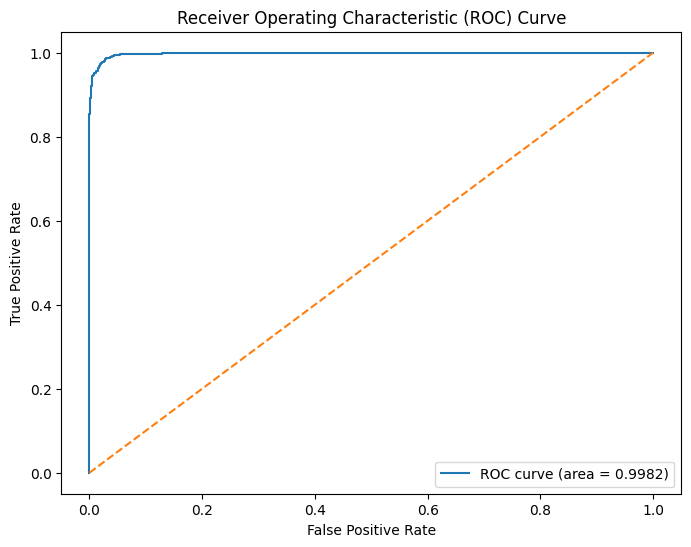

In [3]:
import matplotlib.pyplot as plt
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from transformers import RobertaTokenizer, TFRobertaModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Preprocess text function
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]
    return ' '.join(text)

# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])
combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Tokenization settings
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 128

# Load RoBERTa model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Generator to yield batches of data
def batch_encode(tokenizer, texts, batch_size=32):
    for i in range(0, len(texts), batch_size):
        texts_batch = texts[i:i+batch_size].tolist()
        encodings = tokenizer(texts_batch, padding=True, truncation=True, max_length=max_length, return_tensors='tf')
        yield encodings

# Build classification model
input_layer = Input(shape=(768,))
dense_layer = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# Custom Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8, beta_2=0.898, epsilon=1e-7)

# Compile model
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training and evaluation loop
batch_size = 8
for epoch in range(3):
    print(f"Epoch {epoch+1}/3")
    # Training
    for batch_idx, batch in enumerate(batch_encode(tokenizer, X_train, batch_size=batch_size)):
        embeddings = roberta_model(batch)[0][:,0,:]  # Get the embeddings of the first token ([CLS])
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch['input_ids'].shape[0]
        model.train_on_batch(embeddings, y_train[start_idx:end_idx])

# Evaluation
y_pred = []
for batch in batch_encode(tokenizer, X_test, batch_size=batch_size):
    embeddings = roberta_model(batch)[0][:,0,:]  # Get the embeddings of the first token ([CLS])
    y_pred.extend(model.predict_on_batch(embeddings))

y_pred_binary = np.array(y_pred).flatten() > 0.5
accuracy = accuracy_score(y_test[:len(y_pred_binary)], y_pred_binary)
f1 = f1_score(y_test[:len(y_pred_binary)], y_pred_binary)
conf_matrix = confusion_matrix(y_test[:len(y_pred_binary)], y_pred_binary)

print(f"RoBERTa Classifier - Accuracy: {accuracy}, F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/3
Epoch 2/3
Epoch 3/3
RoBERTa Classifier - Accuracy: 0.9769433465085638, F1 Score: 0.9759780370624571
Confusion Matrix:
[[772  14]
 [ 21 711]]


In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from transformers import RobertaTokenizer, TFRobertaModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, TFRobertaModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Preprocess text function
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]
    return ' '.join(text)

# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])
combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Tokenization settings
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 128

# Load RoBERTa model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Generator to yield batches of data
def batch_encode(tokenizer, texts, batch_size=32):
    for i in range(0, len(texts), batch_size):
        texts_batch = texts[i:i+batch_size].tolist()
        encodings = tokenizer(texts_batch, padding=True, truncation=True, max_length=max_length, return_tensors='tf')
        yield encodings

# Build classification model
input_layer = Input(shape=(768,))
dense_layer = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# Custom Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8, beta_2=0.898, epsilon=1e-7)

# Compile model
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training and evaluation loop
batch_size = 8
for epoch in range(3):
    print(f"Epoch {epoch+1}/3")
    # Training
    for batch_idx, batch in enumerate(batch_encode(tokenizer, X_train, batch_size=batch_size)):
        embeddings = roberta_model(batch)[0][:,0,:]  # Get the embeddings of the first token ([CLS])
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch['input_ids'].shape[0]
        model.train_on_batch(embeddings, y_train[start_idx:end_idx])


Accuracy: 0.9769, F1 Score: 0.9760, Recall: 0.9713, Precision: 0.9807, ROC AUC: 0.9978


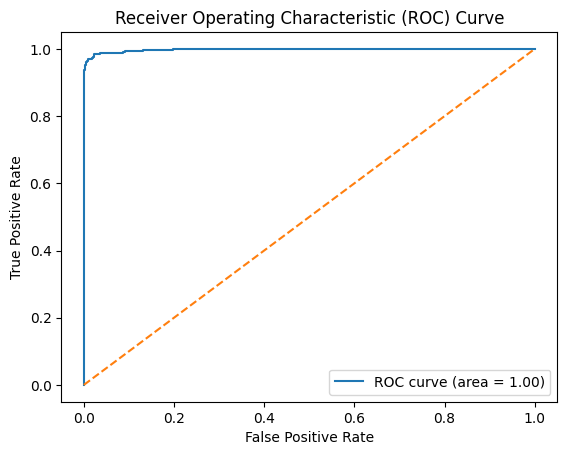

In [5]:
# Evaluation
y_pred = []  # Initialize y_pred
for batch in batch_encode(tokenizer, X_test, batch_size=batch_size):
    embeddings = roberta_model(batch)[0][:,0,:]  # Extract embeddings
    batch_predictions = model.predict_on_batch(embeddings)  # Generate predictions for the current batch
    y_pred.extend(batch_predictions)

# Convert predictions to a numpy array and flatten it for further processing
y_pred_probs = np.array(y_pred).flatten()

# Convert probability predictions to binary predictions based on a 0.5 threshold
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Calculate the metrics using y_pred_binary
accuracy = accuracy_score(y_test[:len(y_pred_binary)], y_pred_binary)
f1 = f1_score(y_test[:len(y_pred_binary)], y_pred_binary)
recall = recall_score(y_test[:len(y_pred_binary)], y_pred_binary)
precision = precision_score(y_test[:len(y_pred_binary)], y_pred_binary)
roc_auc = roc_auc_score(y_test[:len(y_pred_binary)], y_pred_probs)

# Output the metrics
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, ROC AUC: {roc_auc:.4f}")

# # Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test[:len(y_pred_binary)], y_pred_probs)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
